# Training PPO Agent in GridWorld3D-v0 Environment


------------------------------


## Importing required libraries

In [1]:

from __future__ import annotations
import os
import glob
import time
from datetime import datetime

import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal
from torch.distributions import Categorical

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm

import gymnasium as gym
from gymnasium.wrappers import FlattenObservation, RecordEpisodeStatistics,RescaleObservation

import gymnasium_env
import agents
from gymnasium_env import wrappers

In [2]:
gym.pprint_registry()

===== classic_control =====
Acrobot-v1             CartPole-v0            CartPole-v1
MountainCar-v0         MountainCarContinuous-v0 Pendulum-v1
===== phys2d =====
phys2d/CartPole-v0     phys2d/CartPole-v1     phys2d/Pendulum-v0
===== box2d =====
BipedalWalker-v3       BipedalWalkerHardcore-v3 CarRacing-v3
LunarLander-v3         LunarLanderContinuous-v3
===== toy_text =====
Blackjack-v1           CliffWalking-v0        FrozenLake-v1
FrozenLake8x8-v1       Taxi-v3
===== tabular =====
tabular/Blackjack-v0   tabular/CliffWalking-v0
===== mujoco =====
Ant-v2                 Ant-v3                 Ant-v4
Ant-v5                 HalfCheetah-v2         HalfCheetah-v3
HalfCheetah-v4         HalfCheetah-v5         Hopper-v2
Hopper-v3              Hopper-v4              Hopper-v5
Humanoid-v2            Humanoid-v3            Humanoid-v4
Humanoid-v5            HumanoidStandup-v2     HumanoidStandup-v4
HumanoidStandup-v5     InvertedDoublePendulum-v2 InvertedDoublePendulum-v4
InvertedDoublePendulu

## Dummy Example of GrdWorldEnv Dynamics

In [3]:
import gymnasium as gym
from gymnasium.wrappers import RecordEpisodeStatistics, RescaleObservation
from gymnasium_env.wrappers.clip_reward import ClipReward

env = gym.make("GridWorld3D-v0", max_episode_steps=400, render_mode="rgb_array")
env = FlattenObservation(env)
env = RescaleObservation(env, min_obs=0, max_obs=1)
env = RecordEpisodeStatistics(env)

print(env)

<RecordEpisodeStatistics<RescaleObservation<FlattenObservation<TimeLimit<OrderEnforcing<PassiveEnvChecker<GridWorld3DEnv<GridWorld3D-v0>>>>>>>>


{'distance': 52.815872, 'in_cone': 'Target is not in the cone'}


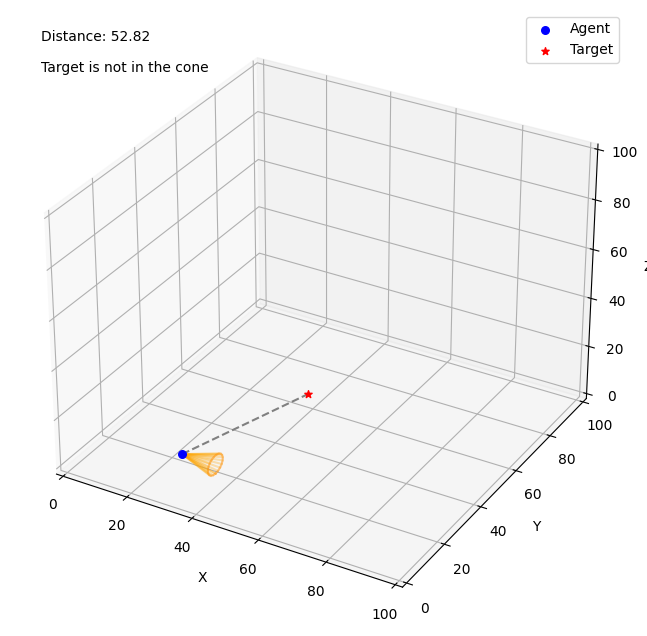

In [ ]:
env= gym.make("GridWorld3D-v0", max_episode_steps=400, render_mode="rgb_array")
obs, info = env.reset()
print(info)
action = env.action_space.sample()


In [ ]:
# debug trace
'''
obs, info = env.reset()
action = env.action_space.sample()  # oppure il tuo agente
print(obs)
print(action)

next_obs, reward, terminated,truncated, info = env.step(action)

print(info["previous_distance"])
print("==========================================================")
print(next_obs)
print(reward)
print(info["current_distance"])
'''

# Proximal Policy Optimization Tutorial

------------------

## Create and initialitize environment hyperparameters

In [3]:
print("============================================================================================")


################################### Training ###################################


####### initialize environment hyperparameters ######

env_name = "GridWorld3D-v0"
has_continuous_action_space = True

max_ep_len = 500                   # max timesteps in one episode
max_training_timesteps = int(1e6)   # break training loop if timeteps > max_training_timesteps

print_freq = max_ep_len * 10     # print avg reward in the interval (in num timesteps)
log_freq = max_ep_len * 2       # log avg reward in the interval (in num timesteps)
save_model_freq = int(1e5)      # save model frequency (in num timesteps)

action_std = 0.6                    # starting std for action distribution (Multivariate Normal)
action_std_decay_rate = 0.05        # linearly decay action_std (action_std = action_std - action_std_decay_rate)
min_action_std = 0.1                # minimum action_std (stop decay after action_std <= min_action_std)
action_std_decay_freq = int(2.5e5)  # action_std decay frequency (in num timesteps)

#####################################################


## Note : print/log frequencies should be > than max_ep_len


################ PPO hyperparameters ################


update_timestep = max_ep_len * 4      # update policy every n timesteps
K_epochs = 40               # update policy for K epochs
eps_clip = 0.2              # clip parameter for PPO
gamma = 0.99                # discount factor

lr_actor = 0.0003       # learning rate for actor network
lr_critic = 0.001       # learning rate for critic network

random_seed = 0         # set random seed if required (0 = no random seed)

#####################################################



print("training environment name : " + env_name )

env = gym.make(env_name)

# flattening the obs space 
env = FlattenObservation(env)

# rescaling the obs space to [0,1]
env = RescaleObservation(env, min_obs=0, max_obs=1)

# wrapping env with RecordEpisodeStatistics
env = RecordEpisodeStatistics(env)

print(env)

# state space dimension
state_dim = env.observation_space.shape[0]

# action space dimension
if has_continuous_action_space:
    action_dim = env.action_space.shape[0]
else:
    action_dim = env.action_space.n

training environment name : GridWorld3D-v0
<RecordEpisodeStatistics<RescaleObservation<FlattenObservation<OrderEnforcing<PassiveEnvChecker<GridWorld3DEnv<GridWorld3D-v0>>>>>>>


### Print Environment Spaces

In [4]:
# Access the observation space of the wrapped environment
obs_space = env.observation_space
print("Observation space:", obs_space)
print("Observation shape:", state_dim)

# Access the action space of the wrapped environment
action_space = env.action_space
print("Action space:", action_space)
print("Observation shape:", action_dim)


Observation space: Box(0.0, 1.0, (6,), float32)
Observation shape: 6
Action space: Box(-1.0, 1.0, (3,), float32)
Observation shape: 3


### Logging

In [5]:
###################### logging ######################

#### log files for multiple runs are NOT overwritten

log_dir = "PPO_logs"
if not os.path.exists(log_dir):
      os.makedirs(log_dir)

log_dir = log_dir + '/' + env_name + '/'
if not os.path.exists(log_dir):
      os.makedirs(log_dir)


#### get number of log files in log directory
run_num = 0
current_num_files = next(os.walk(log_dir))[2]
run_num = len(current_num_files)


#### create new log file for each run 
log_f_name = log_dir + '/PPO_' + env_name + "_log_" + str(run_num) + ".csv"

print("current logging run number for " + env_name + " : ", run_num)
print("logging at : " + log_f_name)

#####################################################

current logging run number for GridWorld3D-v0 :  1
logging at : PPO_logs/GridWorld3D-v0//PPO_GridWorld3D-v0_log_1.csv


### Checkpointing

In [6]:
################### checkpointing ###################

run_num_pretrained = 1      #### change this to prevent overwriting weights in same env_name folder

directory = "PPO_preTrained"
if not os.path.exists(directory):
      os.makedirs(directory)

directory = directory + '/' + env_name + '/'
if not os.path.exists(directory):
      os.makedirs(directory)


checkpoint_path = directory + "PPO_{}_{}_{}.pth".format(env_name, random_seed, run_num_pretrained)
print("save checkpoint path : " + checkpoint_path)

####################################################

save checkpoint path : PPO_preTrained/GridWorld3D-v0/PPO_GridWorld3D-v0_0_1.pth


### Print all the hyperparameters 

In [7]:
############# print all hyperparameters #############

print("--------------------------------------------------------------------------------------------")

print("max training timesteps : ", max_training_timesteps)
print("max timesteps per episode : ", max_ep_len)

print("model saving frequency : " + str(save_model_freq) + " timesteps")
print("log frequency : " + str(log_freq) + " timesteps")
print("printing average reward over episodes in last : " + str(print_freq) + " timesteps")

print("--------------------------------------------------------------------------------------------")

print("state space dimension : ", state_dim)
print("action space dimension : ", action_dim)

print("--------------------------------------------------------------------------------------------")

if has_continuous_action_space:
    print("Initializing a continuous action space policy")
    print("--------------------------------------------------------------------------------------------")
    print("starting std of action distribution : ", action_std)
    print("decay rate of std of action distribution : ", action_std_decay_rate)
    print("minimum std of action distribution : ", min_action_std)
    print("decay frequency of std of action distribution : " + str(action_std_decay_freq) + " timesteps")

else:
    print("Initializing a discrete action space policy")

print("--------------------------------------------------------------------------------------------")

print("PPO update frequency : " + str(update_timestep) + " timesteps") 
print("PPO K epochs : ", K_epochs)
print("PPO epsilon clip : ", eps_clip)
print("discount factor (gamma) : ", gamma)

print("--------------------------------------------------------------------------------------------")

print("optimizer learning rate actor : ", lr_actor)
print("optimizer learning rate critic : ", lr_critic)

if random_seed:
    print("--------------------------------------------------------------------------------------------")
    print("setting random seed to ", random_seed)
    torch.manual_seed(random_seed)
    env.seed(random_seed)
    np.random.seed(random_seed)

#####################################################

--------------------------------------------------------------------------------------------
max training timesteps :  1000000
max timesteps per episode :  500
model saving frequency : 100000 timesteps
log frequency : 1000 timesteps
printing average reward over episodes in last : 5000 timesteps
--------------------------------------------------------------------------------------------
state space dimension :  6
action space dimension :  3
--------------------------------------------------------------------------------------------
Initializing a continuous action space policy
--------------------------------------------------------------------------------------------
starting std of action distribution :  0.6
decay rate of std of action distribution :  0.05
minimum std of action distribution :  0.1
decay frequency of std of action distribution : 250000 timesteps
--------------------------------------------------------------------------------------------
PPO update frequency : 2000 time

## Training PPO Agent

---------

### Initialize The Agent

--------------

In [8]:
################# training procedure ################
from agents.PPO import PPO,RolloutBuffer,ActorCritic
# initialize a PPO agent
ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)

Device set to : cpu


### Training Loop

In [9]:
# track total training time
start_time = datetime.now().replace(microsecond=0)
print("Started training at (GMT) : ", start_time)

print("============================================================================================")


# logging file
log_f = open(log_f_name,"w+")
log_f.write('episode,timestep,reward\n')


# printing and logging variables
print_running_reward = 0
print_running_distance = 0
print_running_episodes = 0

log_running_reward = 0
log_running_episodes = 0

time_step = 0
i_episode = 0




# training loop
while time_step <= max_training_timesteps:
    
    state = env.reset()[0]
    current_ep_reward = 0
    for t in range(1, max_ep_len+1):
        
        # select action with policy
        action = ppo_agent.select_action(state)
        state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        # saving reward and is_terminals
        ppo_agent.buffer.rewards.append(reward)
        ppo_agent.buffer.is_terminals.append(done)
        
        time_step +=1
        current_ep_reward += reward
        

        # update PPO agent
        if time_step % update_timestep == 0:
            ppo_agent.update()

        # if continuous action space; then decay action std of ouput action distribution
        if has_continuous_action_space and time_step % action_std_decay_freq == 0:
            ppo_agent.decay_action_std(action_std_decay_rate, min_action_std)

        # log in logging file
        if time_step % log_freq == 0:

            # log average reward till last episode
            log_avg_reward = log_running_reward / log_running_episodes
            log_avg_reward = round(log_avg_reward, 4)

            log_f.write('{},{},{}\n'.format(i_episode, time_step, log_avg_reward))
            log_f.flush()

            log_running_reward = 0
            log_running_episodes = 0

        # printing average reward
        if time_step % print_freq == 0:

            # print average reward till last episode
            print_avg_reward = print_running_reward / print_running_episodes
            print_avg_reward = round(print_avg_reward, 2)

            print_avg_distance = print_running_distance / print_running_episodes
            print_avg_distance = round(print_avg_distance, 2)

            print("Episode : {} \t\t Timestep : {} \t\t Avg Reward : {} \t\t Avg Distance : {}".format(i_episode, time_step, print_avg_reward, print_avg_distance))

            print_running_reward = 0
            print_running_episodes = 0
            print_running_distance = 0
            print_N_in_cone = 0
            
        # save model weights
        if time_step % save_model_freq == 0:
            print("--------------------------------------------------------------------------------------------")
            print("saving model at : " + checkpoint_path)
            ppo_agent.save(checkpoint_path)
            print("model saved")
            print("Elapsed Time  : ", datetime.now().replace(microsecond=0) - start_time)
            print("--------------------------------------------------------------------------------------------")
            
        # break; if the episode is over
        if done:
            break

    print_running_reward += current_ep_reward
    print_running_distance += info["distance"]
    print_running_episodes += 1

    log_running_reward += current_ep_reward
    log_running_episodes += 1

    i_episode += 1


log_f.close()
env.close()




# print total training time
print("============================================================================================")
end_time = datetime.now().replace(microsecond=0)
print("Started training at (GMT) : ", start_time)
print("Finished training at (GMT) : ", end_time)
print("Total training time  : ", end_time - start_time)
print("============================================================================================")

Started training at (GMT) :  2025-04-30 14:09:59
Episode : 9 		 Timestep : 5000 		 Avg Reward : -5287.26 		 Avg Distance : 69.74
Episode : 19 		 Timestep : 10000 		 Avg Reward : -5025.31 		 Avg Distance : 52.75
Episode : 29 		 Timestep : 15000 		 Avg Reward : -5108.42 		 Avg Distance : 59.82
Episode : 39 		 Timestep : 20000 		 Avg Reward : -4915.12 		 Avg Distance : 51.05
Episode : 49 		 Timestep : 25000 		 Avg Reward : -4913.16 		 Avg Distance : 42.23
Episode : 59 		 Timestep : 30000 		 Avg Reward : -4973.68 		 Avg Distance : 48.9
Episode : 69 		 Timestep : 35000 		 Avg Reward : -4924.12 		 Avg Distance : 49.14
Episode : 79 		 Timestep : 40000 		 Avg Reward : -4708.56 		 Avg Distance : 33.58
Episode : 89 		 Timestep : 45000 		 Avg Reward : -4517.24 		 Avg Distance : 24.07
Episode : 99 		 Timestep : 50000 		 Avg Reward : -4670.6 		 Avg Distance : 31.12
Episode : 109 		 Timestep : 55000 		 Avg Reward : -4569.98 		 Avg Distance : 23.24
Episode : 119 		 Timestep : 60000 		 Avg Reward : -4

## Testing PPO Agent

-----------------

### Setting Hyperparameters

In [10]:

#################################### Testing ###################################


################## hyperparameters ##################

env_name = "GridWorld3D-v0"
has_continuous_action_space = True
max_ep_len = 500
action_std = 0.1

total_test_episodes = 100    # total num of testing episodes

K_epochs = 80               # update policy for K epochs
eps_clip = 0.2              # clip parameter for PPO
gamma = 0.99                # discount factor

lr_actor = 0.0003           # learning rate for actor
lr_critic = 0.001           # learning rate for critic

#####################################################

### Create Testing Environment

In [11]:
print("============================================================================================")

env = gym.make(env_name)
env = FlattenObservation(env)
env = RescaleObservation(env, min_obs=0, max_obs=1)
env = RecordEpisodeStatistics(env)
print(env)
print("============================================================================================")

# state space dimension
state_dim = env.observation_space.shape[0]
print("state space dimension : ", state_dim)

# action space dimension
if has_continuous_action_space:
    action_dim = env.action_space.shape[0]
    print("action space dimension : ", action_dim)
else:
    action_dim = env.action_space.n

print("============================================================================================")


<RecordEpisodeStatistics<RescaleObservation<FlattenObservation<OrderEnforcing<PassiveEnvChecker<GridWorld3DEnv<GridWorld3D-v0>>>>>>>
state space dimension :  6
action space dimension :  3


### Load Trained Models

In [19]:
# initialize a PPO agent
ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)

In [ ]:
# preTrained weights directory

random_seed = 0             #### set this to load a particular checkpoint trained on random seed
run_num_pretrained = 0      #### set this to load a particular checkpoint num


directory = "PPO_preTrained" + '/' + env_name + '/'
checkpoint_path = directory + "PPO_{}_{}_{}.pth".format(env_name, random_seed, run_num_pretrained)
print("loading network from : " + checkpoint_path)

ppo_agent.load(checkpoint_path)

print("--------------------------------------------------------------------------------------------")

### Testing Loop

In [12]:
test_running_reward = 0
test_rewards = []
final_distances = []

for ep in range(1, total_test_episodes+1):
    step = 0
    ep_reward = 0
    in_cone = 0
    state = env.reset()[0]
    
    for t in range(1, max_ep_len+1):
        action = ppo_agent.select_action(state)
        state, reward, terminated,truncated, info = env.step(action)
        ep_reward += reward
        step += 1
        if info["in_cone"] == "Target is in the cone":
            in_cone += 1
        
        done = terminated or truncated
        if done:
            break

    

    # clear buffer    
    ppo_agent.buffer.clear()

    test_rewards.append(ep_reward)
    final_distances.append(info["distance"])

    test_running_reward +=  ep_reward

    print('Episode: {} \t\t Reward: {} \t\t N_steps: {} \t N_in cone: {}'.format(ep, round(ep_reward, 2), step,in_cone))

env.close()


print("============================================================================================")

avg_test_reward = test_running_reward / total_test_episodes
avg_test_reward = round(avg_test_reward, 2)

print("average test reward : " + str(avg_test_reward))



print("============================================================================================")



Episode: 1 		 Reward: 142.67 		 N_steps: 60 	 N_in cone: 3
Episode: 2 		 Reward: -404.23 		 N_steps: 164 	 N_in cone: 4
Episode: 3 		 Reward: 243.38 		 N_steps: 60 	 N_in cone: 2
Episode: 4 		 Reward: 305.9 		 N_steps: 83 	 N_in cone: 4
Episode: 5 		 Reward: 469.69 		 N_steps: 55 	 N_in cone: 5
Episode: 6 		 Reward: 118.28 		 N_steps: 65 	 N_in cone: 2
Episode: 7 		 Reward: -405.59 		 N_steps: 163 	 N_in cone: 4
Episode: 8 		 Reward: 113.33 		 N_steps: 81 	 N_in cone: 2
Episode: 9 		 Reward: 208.23 		 N_steps: 98 	 N_in cone: 4
Episode: 10 		 Reward: -24.76 		 N_steps: 98 	 N_in cone: 5
Episode: 11 		 Reward: -18.48 		 N_steps: 107 	 N_in cone: 3
Episode: 12 		 Reward: 50.23 		 N_steps: 71 	 N_in cone: 1
Episode: 13 		 Reward: -27.84 		 N_steps: 54 	 N_in cone: 1
Episode: 14 		 Reward: -20.21 		 N_steps: 94 	 N_in cone: 1
Episode: 15 		 Reward: 421.12 		 N_steps: 71 	 N_in cone: 3
Episode: 16 		 Reward: 236.86 		 N_steps: 67 	 N_in cone: 0
Episode: 17 		 Reward: 185.54 		 N_steps: 62 	

### Test Plotting

In [ ]:
# =======================
# PLOTTING
# =======================

episodes = list(range(1, total_test_episodes+1))

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot dei reward
color = 'tab:blue'
ax1.set_xlabel('Episode', fontsize=12)
ax1.set_ylabel('Reward', color=color, fontsize=12)
ax1.plot(episodes, test_rewards, color=color, label='Test Reward', marker='o')
ax1.tick_params(axis='y', labelcolor=color)

# Plot dei successi
ax2 = ax1.twinx()  # crea un secondo asse y
color = 'tab:green'
ax2.set_ylabel('Success (0=Fail, 1=Success)', color=color, fontsize=12)
ax2.scatter(episodes, successes, color=color, marker='x', s=100, label='Success', alpha=0.7)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yticks([0, 1])

# Titolo e griglia
plt.title(f"Test Results - Avg Reward: {avg_test_reward} | Success Rate: {success_rate:.2f}%", fontsize=14)
fig.tight_layout()
ax1.grid(True, alpha=0.3)

# Mostra grafico
plt.show()

## Train Plotting

-------------------

loading data from : PPO_logs/GridWorld3D-v0//PPO_GridWorld3D-v0_log_0.csv
data shape :  (833, 3)
--------------------------------------------------------------------------------------------
loading data from : PPO_logs/GridWorld3D-v0//PPO_GridWorld3D-v0_log_1.csv
data shape :  (1000, 3)
--------------------------------------------------------------------------------------------
figure saved at :  PPO_figs/GridWorld3D-v0//PPO_GridWorld3D-v0_fig_0.png


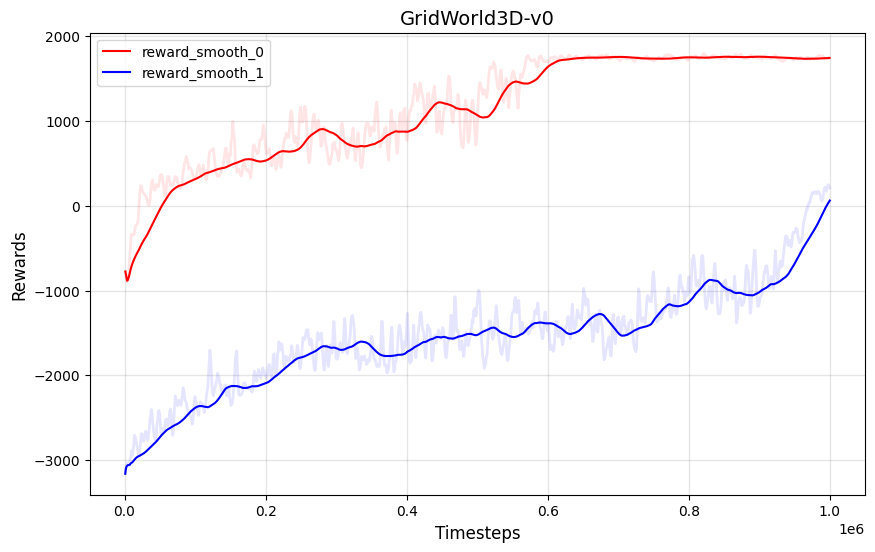

In [13]:

import os
import pandas as pd
import matplotlib.pyplot as plt


print("============================================================================================")

env_name = 'GridWorld3D-v0'

fig_num = 0     #### change this to prevent overwriting figures in same env_name folder

plot_avg = False    # plot average of all runs; else plot all runs separately

fig_width = 10
fig_height = 6


# smooth out rewards to get a smooth and a less smooth (var) plot lines
window_len_smooth = 50
min_window_len_smooth = 1
linewidth_smooth = 1.5
alpha_smooth = 1

window_len_var = 5
min_window_len_var = 1
linewidth_var = 2
alpha_var = 0.1


colors = ['red', 'blue', 'green', 'orange', 'purple', 'olive', 'brown', 'magenta', 'cyan', 'crimson','gray', 'black']


# make directory for saving figures
figures_dir = "PPO_figs"
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)

# make environment directory for saving figures
figures_dir = figures_dir + '/' + env_name + '/'
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)


fig_save_path = figures_dir + '/PPO_' + env_name + '_fig_' + str(fig_num) + '.png'


# get number of log files in directory
log_dir = "PPO_logs" + '/' + env_name + '/'

current_num_files = next(os.walk(log_dir))[2]
num_runs = len(current_num_files)


all_runs = []

for run_num in range(num_runs):

    log_f_name = log_dir + '/PPO_' + env_name + "_log_" + str(run_num) + ".csv"
    print("loading data from : " + log_f_name)
    data = pd.read_csv(log_f_name)
    data = pd.DataFrame(data)
    
    print("data shape : ", data.shape)
    
    all_runs.append(data)
    print("--------------------------------------------------------------------------------------------")


ax = plt.gca()

if plot_avg:
    # average all runs
    df_concat = pd.concat(all_runs)
    df_concat_groupby = df_concat.groupby(df_concat.index)
    data_avg = df_concat_groupby.mean()

    # smooth out rewards to get a smooth and a less smooth (var) plot lines
    data_avg['reward_smooth'] = data_avg['reward'].rolling(window=window_len_smooth, win_type='triang', min_periods=min_window_len_smooth).mean()
    data_avg['reward_var'] = data_avg['reward'].rolling(window=window_len_var, win_type='triang', min_periods=min_window_len_var).mean()

    data_avg.plot(kind='line', x='timestep' , y='reward_smooth',ax=ax,color=colors[0],  linewidth=linewidth_smooth, alpha=alpha_smooth)
    data_avg.plot(kind='line', x='timestep' , y='reward_var',ax=ax,color=colors[0],  linewidth=linewidth_var, alpha=alpha_var)

    # keep only reward_smooth in the legend and rename it
    handles, labels = ax.get_legend_handles_labels()
    ax.legend([handles[0]], ["reward_avg_" + str(len(all_runs)) + "_runs"], loc=2)


else:
    for i, run in enumerate(all_runs):
        # smooth out rewards to get a smooth and a less smooth (var) plot lines
        run['reward_smooth_' + str(i)] = run['reward'].rolling(window=window_len_smooth, win_type='triang', min_periods=min_window_len_smooth).mean()
        run['reward_var_' + str(i)] = run['reward'].rolling(window=window_len_var, win_type='triang', min_periods=min_window_len_var).mean()
        
        # plot the lines
        run.plot(kind='line', x='timestep' , y='reward_smooth_' + str(i),ax=ax,color=colors[i % len(colors)],  linewidth=linewidth_smooth, alpha=alpha_smooth)
        run.plot(kind='line', x='timestep' , y='reward_var_' + str(i),ax=ax,color=colors[i % len(colors)],  linewidth=linewidth_var, alpha=alpha_var)

    # keep alternate elements (reward_smooth_i) in the legend
    handles, labels = ax.get_legend_handles_labels()
    new_handles = []
    new_labels = []
    for i in range(len(handles)):
        if(i%2 == 0):
            new_handles.append(handles[i])
            new_labels.append(labels[i])
    ax.legend(new_handles, new_labels, loc=2)



#ax.set_yticks(np.arange(0, 1800, 200))
#ax.set_xticks(np.arange(0, int(4e6), int(5e5)))


ax.grid(color='gray', linestyle='-', linewidth=1, alpha=0.2)

ax.set_xlabel("Timesteps", fontsize=12)
ax.set_ylabel("Rewards", fontsize=12)

plt.title(env_name, fontsize=14)


fig = plt.gcf()
fig.set_size_inches(fig_width, fig_height)

print("============================================================================================")

plt.savefig(fig_save_path)
print("figure saved at : ", fig_save_path)

print("============================================================================================")


plt.show()




## Test Rendering

In [18]:
"""
One frame corresponding to each timestep is saved in a folder :

PPO_gif_images/env_name/000001.jpg
PPO_gif_images/env_name/000002.jpg
PPO_gif_images/env_name/000003.jpg
...
...
...


if this section is run multiple times or for multiple episodes for the same env_name; 
then the saved images will be overwritten.

"""




#### beginning of virtual display code section

# display = Display(visible=0, size=(400, 300))
# display.start()

#### end of virtual display code section


'\nOne frame corresponding to each timestep is saved in a folder :\n\nPPO_gif_images/env_name/000001.jpg\nPPO_gif_images/env_name/000002.jpg\nPPO_gif_images/env_name/000003.jpg\n...\n...\n...\n\n\nif this section is run multiple times or for multiple episodes for the same env_name; \nthen the saved images will be overwritten.\n\n'

### Creating Test Env

In [14]:

print("============================================================================================")


################## hyperparameters ##################

env_name = "GridWorld3D-v0"
has_continuous_action_space = True
max_ep_len = 300
action_std = 0.1


total_test_episodes = 1     # save gif for only one episode

render_ipython = False      # plot the images using matplotlib and ipythondisplay before saving (slow)

K_epochs = 80               # update policy for K epochs
eps_clip = 0.2              # clip parameter for PPO
gamma = 0.99                # discount factor

lr_actor = 0.0003         # learning rate for actor
lr_critic = 0.001         # learning rate for critic

#####################################################
env = gym.make(env_name, render_mode="rgb_array")
env = FlattenObservation(env)
env = RescaleObservation(env, min_obs=0, max_obs=1)
env = RecordEpisodeStatistics(env)
print(env)

# state space dimension
state_dim = env.observation_space.shape[0]

# action space dimension
if has_continuous_action_space:
    action_dim = env.action_space.shape[0]
else:
    action_dim = env.action_space.n


<RecordEpisodeStatistics<RescaleObservation<FlattenObservation<OrderEnforcing<PassiveEnvChecker<GridWorld3DEnv<GridWorld3D-v0>>>>>>>


### Saving Gif

In [15]:
# make directory for saving gif images
gif_images_dir = "PPO_gif_images" + '/'
if not os.path.exists(gif_images_dir):
    os.makedirs(gif_images_dir)

# make environment directory for saving gif images
gif_images_dir = gif_images_dir + '/' + env_name + '/'
if not os.path.exists(gif_images_dir):
    os.makedirs(gif_images_dir)

# make directory for gif
gif_dir = "PPO_gifs" + '/'
if not os.path.exists(gif_dir):
    os.makedirs(gif_dir)

# make environment directory for gif
gif_dir = gif_dir + '/' + env_name  + '/'
if not os.path.exists(gif_dir):
    os.makedirs(gif_dir)

### Loading Model

In [ ]:

ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)


# preTrained weights directory

random_seed = 0             #### set this to load a particular checkpoint trained on random seed
run_num_pretrained = 0      #### set this to load a particular checkpoint num


directory = "PPO_preTrained" + '/' + env_name + '/'
checkpoint_path = directory + "PPO_{}_{}_{}.pth".format(env_name, random_seed, run_num_pretrained)
print("loading network from : " + checkpoint_path)

ppo_agent.load(checkpoint_path)

print("--------------------------------------------------------------------------------------------")

### Testing Loop

In [16]:

import os
import glob

import gym
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

test_running_reward = 0

for ep in range(1, total_test_episodes+1):
    
    ep_reward = 0
    state = env.reset()[0]

    for t in range(1, max_ep_len+1):
    
        action = ppo_agent.select_action(state)
        
        state, reward, terminated,truncated, info = env.step(action)
        ep_reward += reward

        img = env.render()


        #### beginning of ipythondisplay code section 1
        if render_ipython:
            plt.imshow(img)
            plt.axis('off')

            ipythondisplay.clear_output(wait=True)
            ipythondisplay.display(plt.gcf())
        
        #### end of ipythondisplay code section 1


        img = Image.fromarray(img)
        img.save(gif_images_dir + '/' + str(t).zfill(6) + '.jpg')
        
        if terminated or truncated:
            break
    
    # clear buffer    
    ppo_agent.buffer.clear()
    
    test_running_reward +=  ep_reward
    print('Episode: {} \t\t Reward: {} \t\t Final distance: {}'.format(ep, round(ep_reward, 2), info["distance"]))
    ep_reward = 0



env.close()


#### beginning of ipythondisplay code section 2

if render_ipython:
    ipythondisplay.clear_output(wait=True)

#### end of ipythondisplay code section 2




print("============================================================================================")

print("total number of frames / timesteps / images saved : ", t)

avg_test_reward = test_running_reward / total_test_episodes
avg_test_reward = round(avg_test_reward, 2)
print("average test reward : " + str(avg_test_reward))

print("============================================================================================")







Episode: 1 		 Reward: 285.64 		 Final distance: 0.6724737286567688
total number of frames / timesteps / images saved :  170
average test reward : 285.64


### Creating Gifs

In [17]:

######################## generate gif from saved images ########################


print("============================================================================================")

env_name = 'GridWorld3D-v0'
# env_name = 'LunarLander-v2'
# env_name = 'BipedalWalker-v2'
# env_name = 'RoboschoolWalker2d-v1'


gif_num = 1     #### change this to prevent overwriting gifs in same env_name folder

# adjust following parameters to get desired duration, size (bytes) and smoothness of gif
total_timesteps = 170
step = 1
frame_duration = 500


# input images
gif_images_dir = "PPO_gif_images/" + env_name + '/*.jpg'


# ouput gif path
gif_dir = "PPO_gifs"
if not os.path.exists(gif_dir):
    os.makedirs(gif_dir)

gif_dir = gif_dir + '/' + env_name
if not os.path.exists(gif_dir):
    os.makedirs(gif_dir)

gif_path = gif_dir + '/PPO_' + env_name + '_gif_' + str(gif_num) + '.gif'



img_paths = sorted(glob.glob(gif_images_dir))
img_paths = img_paths[:total_timesteps]
img_paths = img_paths[::step]


print("total frames in gif : ", len(img_paths))
print("total duration of gif : " + str(round(len(img_paths) * frame_duration / 1000, 2)) + " seconds")



# save gif
img, *imgs = [Image.open(f) for f in img_paths]
img.save(fp=gif_path, format='GIF', append_images=imgs, save_all=True, optimize=True, duration=frame_duration, loop=0)

print("saved gif at : ", gif_path)



print("============================================================================================")

total frames in gif :  170
total duration of gif : 85.0 seconds
saved gif at :  PPO_gifs/GridWorld3D-v0/PPO_GridWorld3D-v0_gif_1.gif
